<a href="https://colab.research.google.com/github/reznimat/ppzd_sp/blob/main/semestralni_prace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Načtení knihoven

In [1]:
import csv
import pandas as pd
import math as mt
import datetime as dt
from matplotlib import pyplot as plt
from tabulate import tabulate

print('knihovny načteny')

knihovny načteny


# Načtení datových souborů

In [25]:
# POZOR, pouze vzorek dat
#url_sales = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/SAMPLE_Online_Sales.csv'
url_sales = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Online_Sales.csv'
df_sales = pd.read_csv(url_sales)

url_coupons = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Discount_Coupon.csv'
df_coupons = pd.read_csv(url_coupons,sep=";")

url_tax = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Tax_amount.csv' #původní GST ve formátu 10% ručně upraveno na GST_pct ve formátu 10 (18 položek)
df_tax = pd.read_csv(url_tax,sep=";")

print('datové soubory načteny')

datové soubory načteny


# Číselníky

In [26]:
# Čísleník měsíců
c_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')

# Čísleník produktových kategorií
c_product_category = set()
for i, row in df_sales.iterrows():
  c_product_category.add(row["Product_Category"])

#print(c_product_category)  # vypíše seznam produktových kategorií
#print(c_months)

print('číselníky vytvořeny')

číselníky vytvořeny


# Definice funkcí

In [27]:
# funkce pro výpočet sales_amount po slevě na úrovni item
# není zohledněna doprava (předpoklad, že ta je relevantní pro úroveň transaction)
def Revenue(row):
    if row["Coupon_Status"] == 'Not Used':
      return (row["Quantity"]*row["Avg_Price"]) #*(1+(row["GST_pct"]/100))
    else:
      return (row["Quantity"]*row["Avg_Price"])*(1-(row["Discount_pct"]/100)) #*(1+(row["GST_pct"]/100))

# Převod Transaction_Date ve formátu m/d/Y (1/20/2019) na month abrevation (Jan)
def MonthAbrv(row):
    return pd.to_datetime(row.Transaction_Date,format='%m/%d/%Y').strftime("%b")

print('funkce definovány')

funkce definovány


# Calculate revenue for each transaction and item level

 - Hint:
  - InvoiceValue = (( QuantityAvg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges
  - Revenue = (Quantity Avg_price)*(1-Dicount_pct)


## Obohacení df_sales o atribut Month (Date Abrv)

In [28]:
df_sales['Month'] = df_sales.apply(MonthAbrv, axis=1)

print('v df_sales je nyní sloupec Month\n')
print(df_sales.head().to_markdown())


v df_sales je nyní sloupec Month

|    |   CustomerID |   Transaction_ID | Transaction_Date   | Product_SKU    | Product_Description                                    | Product_Category   |   Quantity |   Avg_Price |   Delivery_Charges | Coupon_Status   | Month   |
|---:|-------------:|-----------------:|:-------------------|:---------------|:-------------------------------------------------------|:-------------------|-----------:|------------:|-------------------:|:----------------|:--------|
|  0 |        17850 |            16679 | 1/1/2019           | GGOENEBJ079499 | Nest Learning Thermostat 3rd Gen-USA - Stainless Steel | Nest-USA           |          1 |      153.71 |                6.5 | Used            | Jan     |
|  1 |        17850 |            16680 | 1/1/2019           | GGOENEBJ079499 | Nest Learning Thermostat 3rd Gen-USA - Stainless Steel | Nest-USA           |          1 |      153.71 |                6.5 | Used            | Jan     |
|  2 |        17850 |            1

## Spojení df_sales s df_coupons

In [29]:
#Merge Sales a Coupons na základě Product_Category a Month
df_sales = pd.merge(df_sales,df_coupons, on=["Product_Category","Month"])

#Merge Sales a Tax na základe Product_Category
# df_sales = pd.merge(df_sales,df_tax, on=["Product_Category"])

print('do df_sales byly připojeny data z df_coupons\n')
print(df_sales.head().to_markdown())

do df_sales byly připojeny data z df_coupons

|    |   CustomerID |   Transaction_ID | Transaction_Date   | Product_SKU    | Product_Description                                    | Product_Category   |   Quantity |   Avg_Price |   Delivery_Charges | Coupon_Status   | Month   | Coupon_Code   |   Discount_pct |
|---:|-------------:|-----------------:|:-------------------|:---------------|:-------------------------------------------------------|:-------------------|-----------:|------------:|-------------------:|:----------------|:--------|:--------------|---------------:|
|  0 |        17850 |            16679 | 1/1/2019           | GGOENEBJ079499 | Nest Learning Thermostat 3rd Gen-USA - Stainless Steel | Nest-USA           |          1 |      153.71 |                6.5 | Used            | Jan     | ELEC10        |             10 |
|  1 |        17850 |            16680 | 1/1/2019           | GGOENEBJ079499 | Nest Learning Thermostat 3rd Gen-USA - Stainless Steel | Nest-USA           |

## Obohacení df_sales o Revenue

In [30]:
# nejsou započítány náklady na dopravu a daně
df_sales["Revenue"] = df_sales.apply(Revenue,axis = 1)

print('df_sales bylo obohaceno o sloupec Revenue\n')
print(df_sales.head().to_markdown())


df_sales bylo obohaceno o sloupec Revenue

|    |   CustomerID |   Transaction_ID | Transaction_Date   | Product_SKU    | Product_Description                                    | Product_Category   |   Quantity |   Avg_Price |   Delivery_Charges | Coupon_Status   | Month   | Coupon_Code   |   Discount_pct |   Revenue |
|---:|-------------:|-----------------:|:-------------------|:---------------|:-------------------------------------------------------|:-------------------|-----------:|------------:|-------------------:|:----------------|:--------|:--------------|---------------:|----------:|
|  0 |        17850 |            16679 | 1/1/2019           | GGOENEBJ079499 | Nest Learning Thermostat 3rd Gen-USA - Stainless Steel | Nest-USA           |          1 |      153.71 |                6.5 | Used            | Jan     | ELEC10        |             10 |   138.339 |
|  1 |        17850 |            16680 | 1/1/2019           | GGOENEBJ079499 | Nest Learning Thermostat 3rd Gen-USA - Stain

## Revenue per transaction


In [41]:
df = df_sales[["Transaction_ID","Transaction_Date","Month","Revenue"]]

df2 = df.groupby(by=["Transaction_ID","Transaction_Date","Month"]).sum(["Revenue"])

print(df2.head().to_markdown())

|                            |   Revenue |
|:---------------------------|----------:|
| (16679, '1/1/2019', 'Jan') |   138.339 |
| (16680, '1/1/2019', 'Jan') |   138.339 |
| (16681, '1/1/2019', 'Jan') |     1.845 |
| (16682, '1/1/2019', 'Jan') |   634.916 |
| (16684, '1/1/2019', 'Jan') |   294.336 |


## Tržby po kategoriích a měsících

In [42]:
Month_Category_Sales = df_sales[["Transaction_Date","Month","Product_Category","Revenue"]]

print(Month_Category_Sales.head().to_markdown())

|    | Transaction_Date   | Month   | Product_Category   |   Revenue |
|---:|:-------------------|:--------|:-------------------|----------:|
|  0 | 1/1/2019           | Jan     | Nest-USA           |   138.339 |
|  1 | 1/1/2019           | Jan     | Nest-USA           |   138.339 |
|  2 | 1/1/2019           | Jan     | Nest-USA           |   220.986 |
|  3 | 1/1/2019           | Jan     | Nest-USA           |    73.35  |
|  4 | 1/1/2019           | Jan     | Nest-USA           |   110.493 |


### Pokus o graf - groupby ale udělal z měsíců indexy a řadí je teď podle abecedy

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.base.Index'>
         Revenue
Month           
Apr    80949.670
Aug    44199.104
Dec    36533.925
Feb    31479.736
Jan    35093.928
Jul    59711.047
Jun    33868.464
Mar    44846.421
May    49009.162
Nov    15374.506
Oct    19861.988
Sep    41633.391


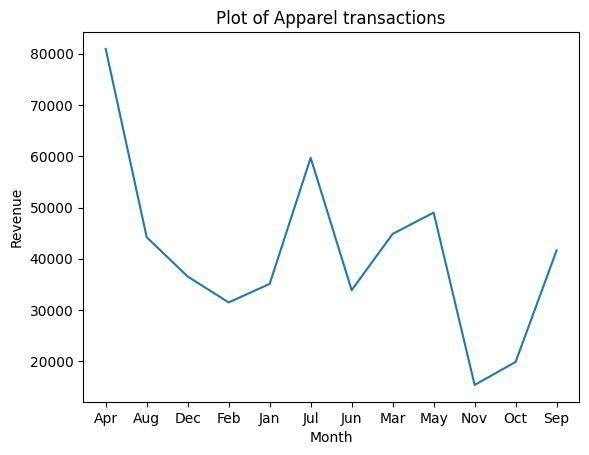

In [40]:
# Function to sort based on the month_order list
df=Month_Category_Sales

# Specify categories to plot
categories_to_plot = ['Apparel']

# Filter data for desired categories
filtered_data = df[df['Product_Category'].isin(categories_to_plot)]

plot_input=filtered_data.groupby('Month').sum('Revenue')
#plot_input['month_datetime'] = pd.to_datetime(plot_input.index)

print(type(df.index))
print(type(plot_input.index))

print(type(plot_input.index))
print(plot_input)

#plot_input = plot_input.set_index('month_datetime')
#plot_input = plot_input.sort_index()



# Create your plot (replace with your desired plot type)

plt.plot(plot_input.index, plot_input["Revenue"])
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Plot of Apparel transactions')
plt.show()

### Funkční (ale nekonečný) výpočet měsíčních prodejů po kategoriích

In [43]:
work_list = []

for mesic in c_months:
  for kategorie in c_product_category:
    CategoryRevenue = 0
    for i, row in df_sales.iterrows():
      if row.Product_Category == kategorie and row.Month == mesic:
        CategoryRevenue += row.Revenue
    work_list.append((kategorie, mesic, CategoryRevenue)) # append vypočítaný záznam do listu
#    print()
#    slovnik["kategorie"] = kategorie
#    slovnik["mesic"] = mesic
#    slovnik["Sales"] = CategorySales

df_CatMonSales = pd.DataFrame.from_records(work_list, columns=['kategorie', 'mesic','CategoryRevenue']) # převod listu na data_frame

print(df_CatMonSales.head().to_markdown())

|    | kategorie   | mesic   |   CategoryRevenue |
|---:|:------------|:--------|------------------:|
|  0 | More Bags   | Jan     |             0     |
|  1 | Housewares  | Jan     |           903.532 |
|  2 | Accessories | Jan     |            46.413 |
|  3 | Drinkware   | Jan     |         13378     |
|  4 | Nest        | Jan     |             0     |


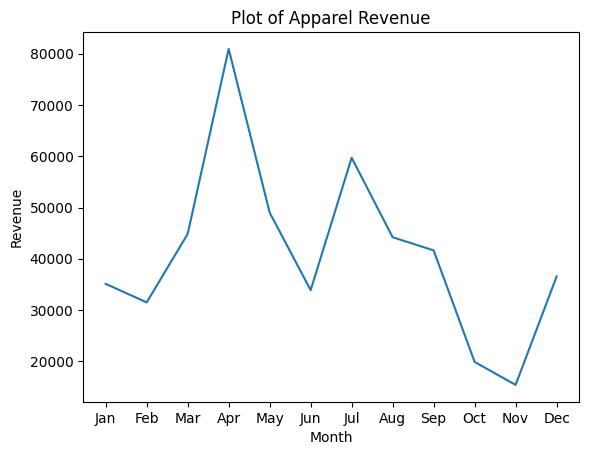

In [44]:
# Specify categories to plot
categories_to_plot = ['Apparel']

# Filter data for desired categories
filtered_data = df_CatMonSales[df_CatMonSales['kategorie'].isin(categories_to_plot)]

# Create plot (replace with your desired plot type)
plt.plot(filtered_data["mesic"], filtered_data["CategoryRevenue"])
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Plot of Apparel Revenue')
plt.show()